In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
config=tf.ConfigProto()
config.gpu_options.allow_growth=True
tf.keras.backend.set_session(tf.Session(config=config))

from tf.keras.layers import Activation,Dense,Input,concatenate
from tf.keras.layers import Conv2D, Flatten, Conv2DTranspose, LeakyReLU, BatchNormalization
from tf.keras.optimizers import RMSprop, Adam
from tf.keras.models import Model, load_model, Sequential
from tf.keras.layers import Reshape, Dropout,ZeroPadding2D,Add, add
from tensorflow.keras import backend as k
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
#from models.layers.layers import ReflectionPadding2D
from tensorflow.keras.utils import plot_model
import scipy
import matplotlib.pyplot as plt
import numpy as np
import os
import other_utils
import instancenormalization

In [2]:
def build_generator_unet(input_shape,output_shape,kernel_size,gen_n_filters):
    def encoder(layer_input,filters,strides=2,activation='relu'):
        conv=Conv2D(filters,kernel_size=kernel_size,strides=strides,padding='same')
        d=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(layer_input)
        #d=BatchNormalization(axis=-1)(layer_input)
        if activation=='relu':
            d=Activation('relu')(d)
        else:
            d=LeakyReLU(alpha=0.2)(d)
        d=conv(d)
        return d
    
    def decoder(layer_input,concate_input,filters,activation='relu'):
        conv=Conv2DTranspose(filters,kernel_size=kernel_size,strides=2,padding='same')
        u=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(layer_input)
        #u=BatchNormalization(axis=-1)(layer_input)
        if activation=='relu':
            u=Activation('relu')(u)
        else:
            u=LeakyReLU(alpha=0.2)(u)
        u=conv(u)
        u=concatenate([u,concate_input])
        return u
    
    img=Input(shape=input_shape)
    channels=int(output_shape[-1])
    
    d1=encoder(img, gen_n_filters,strides=1,activation='notrelu')
    d2=encoder(d1,gen_n_filters*2,activation='notrelu')
    d3=encoder(d2, gen_n_filters*4,activation='notrelu')
    d4=encoder(d3, gen_n_filters*8,activation='notrelu')
    u1=decoder(d4,d3, gen_n_filters*4)
    u2=decoder(u1,d2, gen_n_filters*2)
    u3=decoder(u2,d1, gen_n_filters)
    
    output=Conv2DTranspose(channels,kernel_size=kernel_size, strides=1, padding='same', activation='relu')(u3)
    generator=Model(img,output)
    return generator

In [3]:
def build_generator_resnet(input_shape,kernel_size,gen_n_filters,output_shape=None):
    def conv7s1(layer_input,filters,final):
        #y=ReflectionPadding2D(padding=(3,3))(layer_input)
        #y=Conv2D(filters,kernel_size=(7,7),strides=1,padding='valid')(y)
        y=Conv2D(filters,kernel_size=(7,7),strides=1,padding='same')(layer_input)
        if final:
            y=Activation('tanh')(y)
        else:
            y=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(y)
            #y=BatchNormalization(axis=-1,center=False,scale=False)(y)
            y=Activation('relu')(y)
        return y
    def encoder(layer_input,filters):
        y=Conv2D(filters,kernel_size=kernel_size,strides=2,padding='same')(layer_input)
        y=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        #y=BatchNormalization(axis=-1, center=False, scale=False)(y)
        y=Activation('relu')(y)
        return y
    def residual(layer_input,filters):
        short_cut=layer_input
        #y=ReflectionPadding2D(padding=(1,1))(layer_input)
        y=Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(layer_input)
        y=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        #y=Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(layer_input)
        #y=BatchNormalization(axis=-1, center=False, scale=False)(y)
        y=Activation('relu')(y)
        
        #y=ReflectionPadding2D(padding=(1,1))(y)
        y=Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(y)
        y=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        #y=Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(y)
        #y=BatchNormalization(axis=-1, center=False, scale=False)(y)
        
        return add([short_cut,y])
    
    def decoder(layer_input,filters):
        y=Conv2DTranspose(filters,kernel_size=kernel_size,strides=2,padding='same')(layer_input)
        y=instancenormalization.InstanceNormalization(axis=-1, center=False,scale=False)(y)
        #y=BatchNormalization(axis=-1, center=False, scale=False)(y)
        y=Activation('relu')(y)
        return u
    
    img=Input(shape=input_shape)
    channels=int(output_shape[-1])
    y=conv7s1(img,gen_n_filters,False)
    y=encoder(y,gen_n_filters*2)
    y=encoder(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=residual(y,gen_n_filters*4)
    y=decoder(y,gen_n_filters*2)
    y=decoder(y,gen_n_filters)
    output=conv7s1(y,channels,True)
    generator=Model(img,output)
    return generator
            
        

In [4]:
def build_discriminator(input_shape,kernel_size,dis_n_filters,patchgan=False):
    def conv(layer_input,filters,strides=2):
        conv=Conv2D(filters,kernel_size=kernel_size,strides=strides,padding='same')
        y=LeakyReLU(0.2)(layer_input)
        y=conv(y)
        return y
    img=Input(shape=input_shape)
    y=conv(img,dis_n_filters)
    y=conv(y,dis_n_filters*2)
    y=conv(y,dis_n_filters*4)
    y=conv(y,dis_n_filters*8)
    if patchgan:
        y=LeakyReLU(alpha=0.2)(y)
        output=Conv2D(1,kernel_size=kernel_size,strides=1,padding='same')(y)
    else:
        y=Flatten()(y)
        y=Dense(1)(y)
        output=Activation('linear')(y)
    discriminator=Model(img,output)
    return discriminator
            

In [5]:
def build_cyclegan(shapes,dis_n_filters,gen_n_filters,kernel_size,unet=True,patchgan=False,identity=False):
    A_shape, B_shape=shapes
    d_A=build_discriminator(A_shape,kernel_size,dis_n_filters,patchgan=patchgan)
    d_B=build_discriminator(B_shape,kernel_size,dis_n_filters,patchgan=patchgan)
    d_A.summary()
    d_B.summary()
    d_A.compile(loss='mse',optimizer=RMSprop(lr=2e-4,decay=6e-8))
    d_B.compile(loss='mse',optimizer=RMSprop(lr=2e-4,decay=6e-8))
    #d_A.summary()
    #d_B.summary()
    if unet:
        g_AB=build_generator_unet(A_shape,B_shape,kernel_size,gen_n_filters)
        g_BA=build_generator_unet(B_shape,A_shape,kernel_size,gen_n_filters)
    else:
        g_AB=build_generator_resnet(A_shape,B_shape,kernel_size,gen_n_filters)
        g_BA=build_generator_resnet(B_shape,A_shape,kernel_size,gen_n_filters)
    
    d_A.trainable=False
    d_B.trainable=False
    g_AB.summary()
    g_BA.summary()
    img_A=Input(shape=A_shape)
    img_B=Input(shape=B_shape)
    fake_A=g_BA(img_B)
    fake_B=g_AB(img_A)
    valid_A=d_A(fake_A)
    valid_B=d_B(fake_B)
    recons_A=g_BA(fake_B)
    recons_B=g_AB(fake_A)
    
    if identity:
        img_A_id=g_BA(img_A)
        img_B_id=g_AB(img_B)
        inputs=[img_A, img_B]
        outputs=[valid_A, valid_B, recons_A, recons_B, img_A_id, img_B_id]
        loss=['mse','mse','mae','mae','mae','mae']
        loss_weights=[1.,1.,10.,10.,0.5,0.5]
    else:
        inputs=[img_A,img_B]
        outputs=[valid_A, valid_B, recons_A, recons_B]
        loss=['mse','mse','mae','mae']
        loss_weights=[1.5,1.,10.,8.]
    
    adv=Model(inputs, outputs)
    adv.compile(loss=loss, optimizer=RMSprop(lr=2e-4,decay=6e-8), loss_weights=loss_weights)
    #adv.summary()
    return d_A, d_B, g_AB, g_BA, adv
    
        
        

Using TensorFlow backend.


((32, 32, 1), (32, 32, 3))
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
___________________________________________

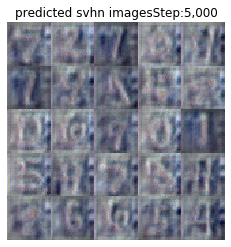

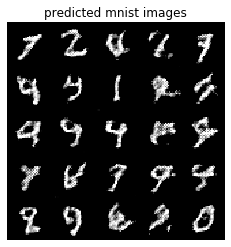

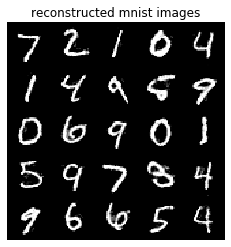

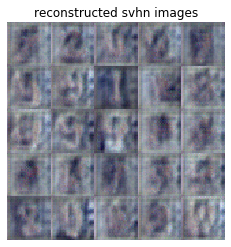

10000:[d_A loss:0.144271]:[d_B loss:0.024201][adv loss:5.193067]


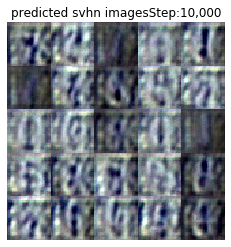

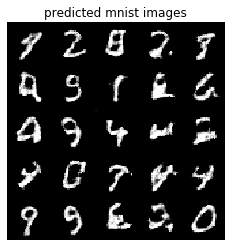

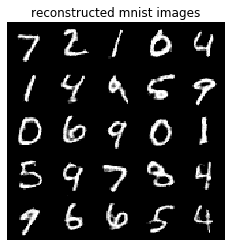

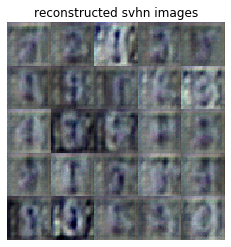

15000:[d_A loss:0.126270]:[d_B loss:0.621193][adv loss:3.917796]


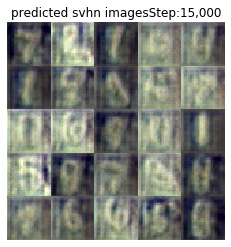

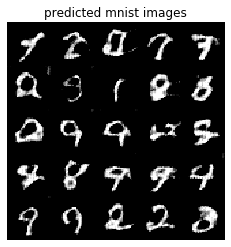

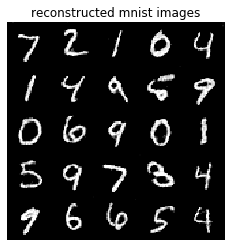

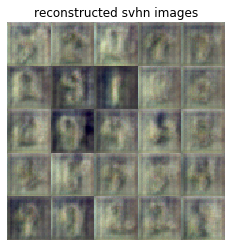

20000:[d_A loss:0.152168]:[d_B loss:0.148602][adv loss:4.550916]


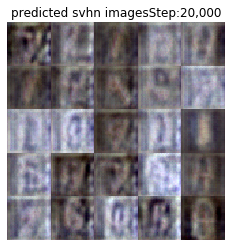

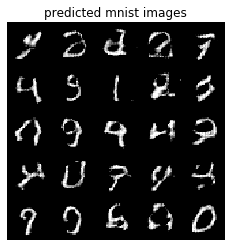

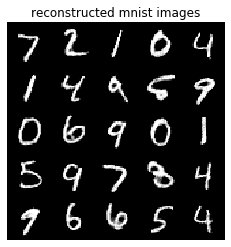

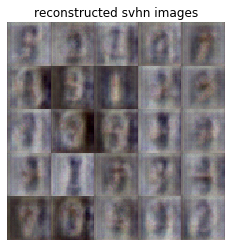

25000:[d_A loss:0.109586]:[d_B loss:0.092608][adv loss:4.985244]


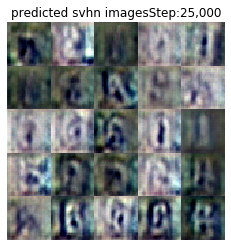

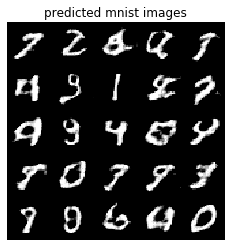

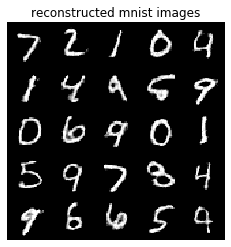

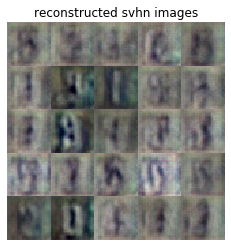

30000:[d_A loss:0.055422]:[d_B loss:0.144901][adv loss:4.788945]


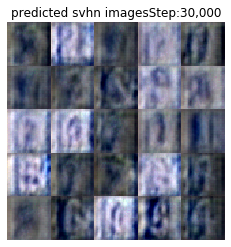

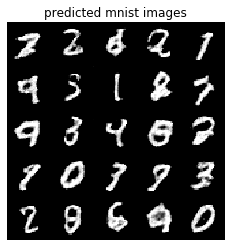

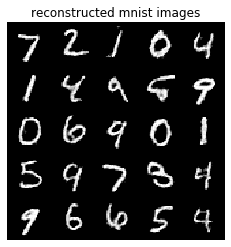

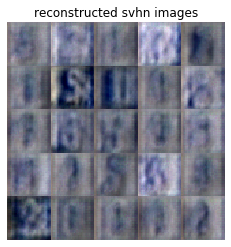

35000:[d_A loss:0.262596]:[d_B loss:0.301423][adv loss:4.982999]


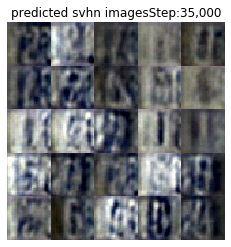

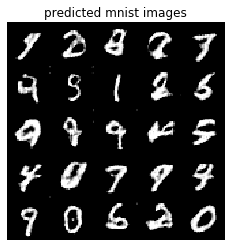

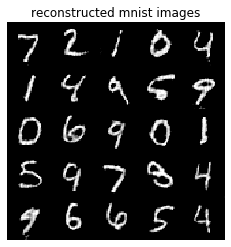

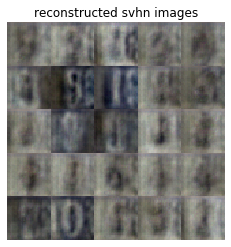

40000:[d_A loss:0.186607]:[d_B loss:0.242143][adv loss:5.166196]


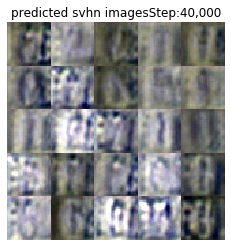

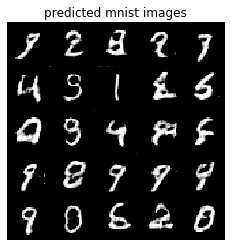

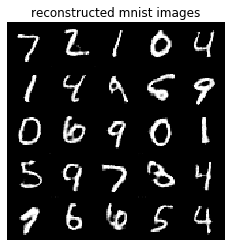

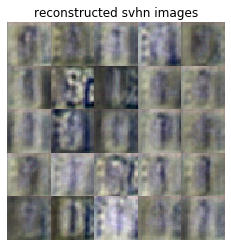

45000:[d_A loss:0.093448]:[d_B loss:0.175765][adv loss:6.347802]


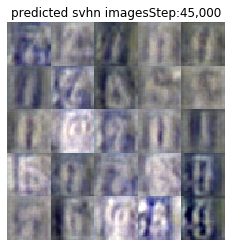

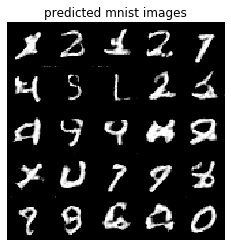

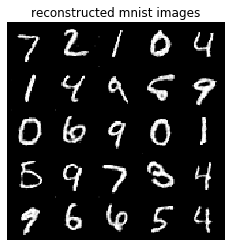

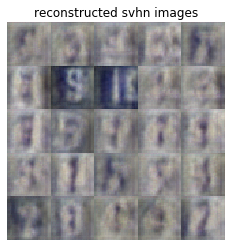

50000:[d_A loss:0.090374]:[d_B loss:0.300520][adv loss:4.395358]


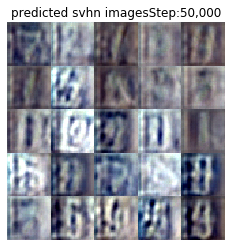

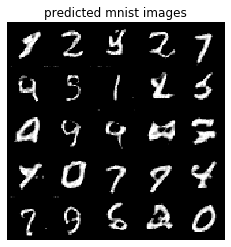

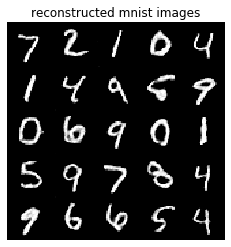

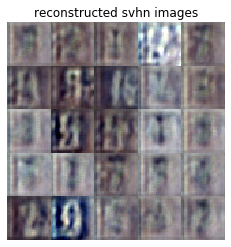

55000:[d_A loss:0.053366]:[d_B loss:0.207283][adv loss:6.168476]


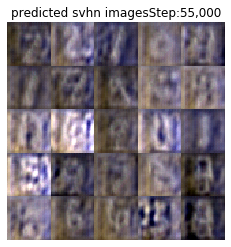

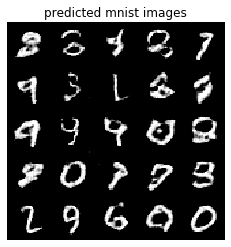

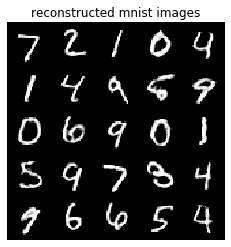

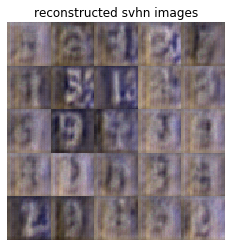

60000:[d_A loss:0.200661]:[d_B loss:0.014772][adv loss:3.893787]


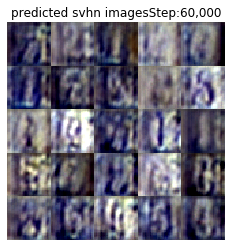

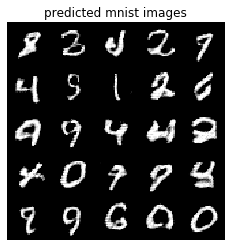

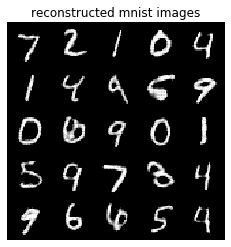

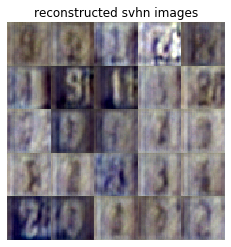

65000:[d_A loss:0.205639]:[d_B loss:0.270987][adv loss:4.743551]


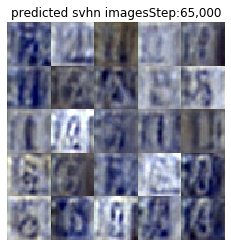

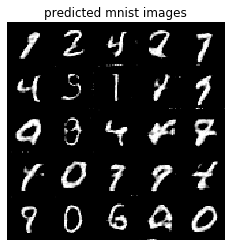

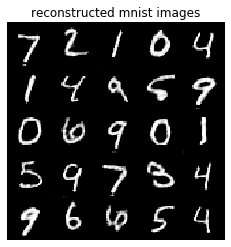

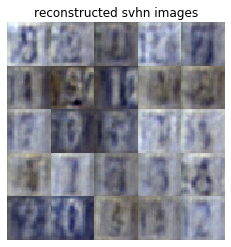

70000:[d_A loss:0.468623]:[d_B loss:0.136843][adv loss:4.060693]


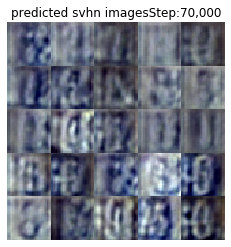

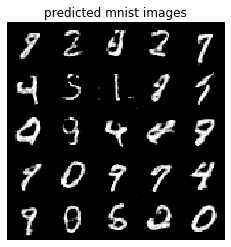

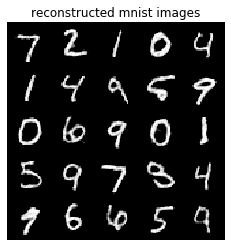

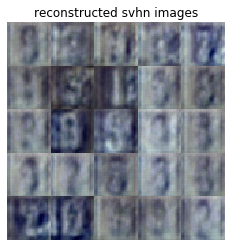

75000:[d_A loss:0.269696]:[d_B loss:0.252235][adv loss:5.024016]


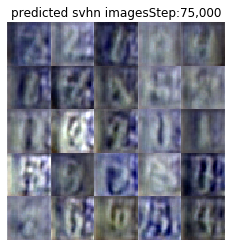

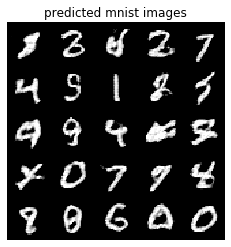

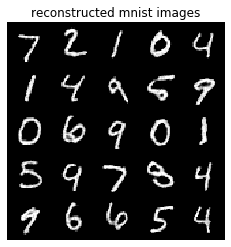

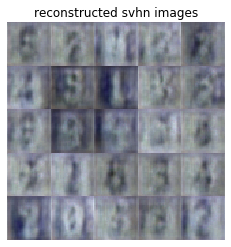

80000:[d_A loss:0.107232]:[d_B loss:0.195717][adv loss:4.987303]


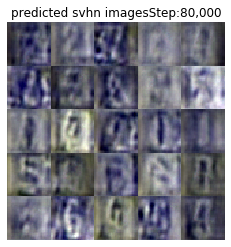

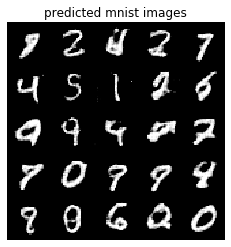

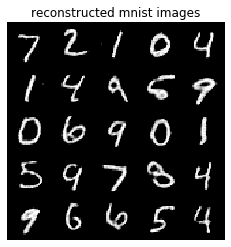

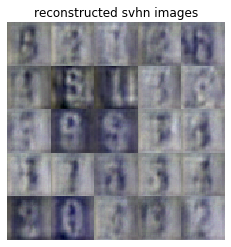

85000:[d_A loss:0.088691]:[d_B loss:0.023565][adv loss:5.653815]


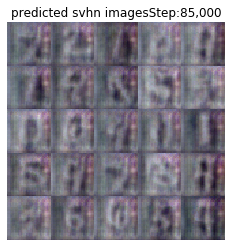

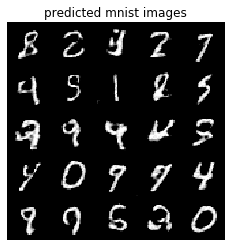

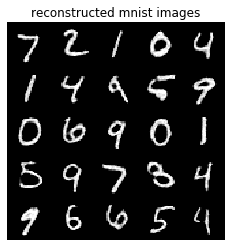

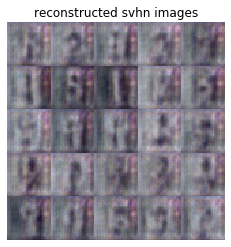

90000:[d_A loss:0.095304]:[d_B loss:0.312912][adv loss:4.172559]


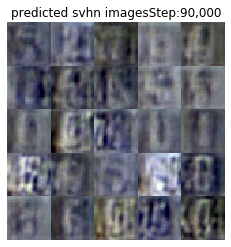

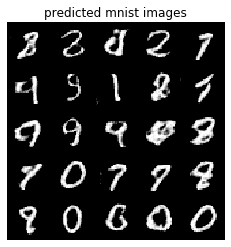

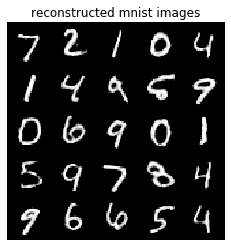

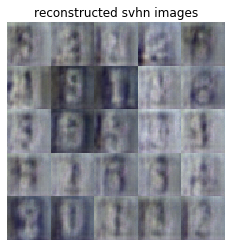

95000:[d_A loss:0.044519]:[d_B loss:0.000940][adv loss:4.885679]


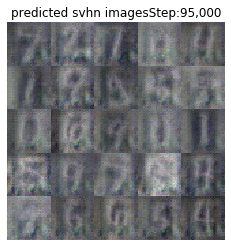

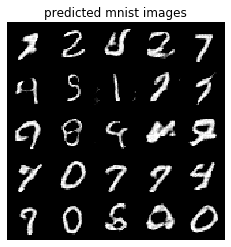

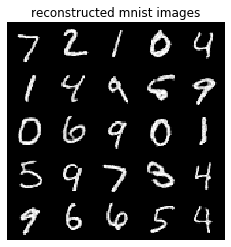

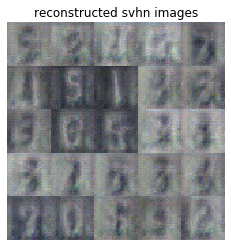

100000:[d_A loss:0.167069]:[d_B loss:0.001165][adv loss:4.117466]


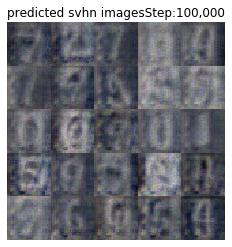

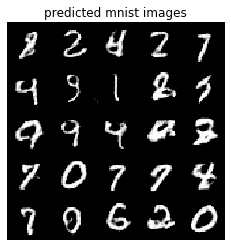

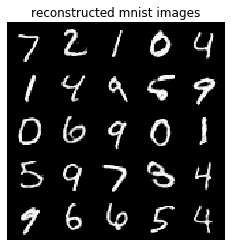

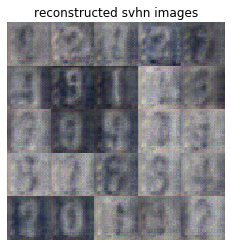

105000:[d_A loss:0.015238]:[d_B loss:0.846812][adv loss:4.506001]


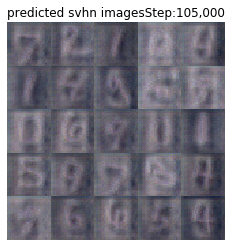

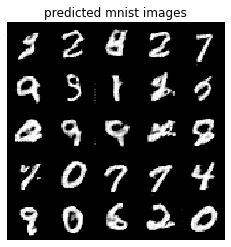

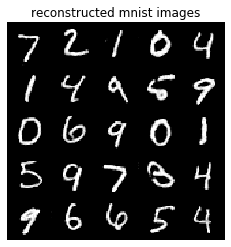

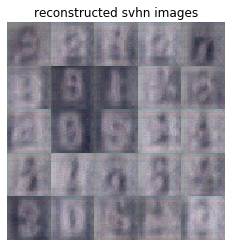

110000:[d_A loss:0.185500]:[d_B loss:0.000324][adv loss:3.927943]


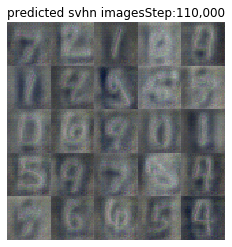

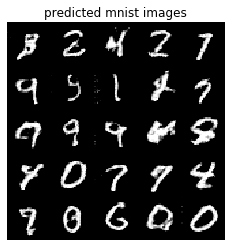

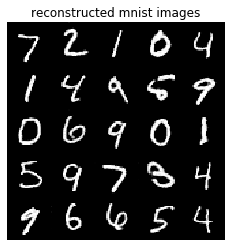

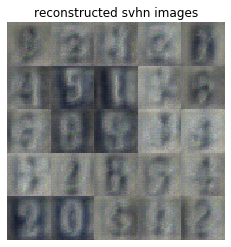

115000:[d_A loss:0.055114]:[d_B loss:0.000538][adv loss:4.234420]


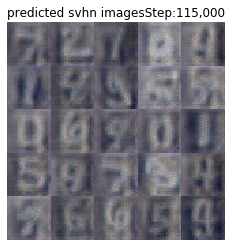

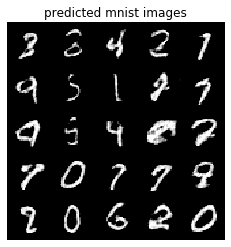

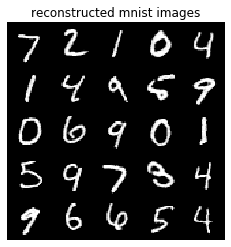

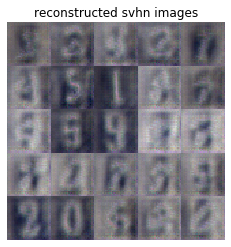

120000:[d_A loss:0.025090]:[d_B loss:0.000162][adv loss:5.877768]


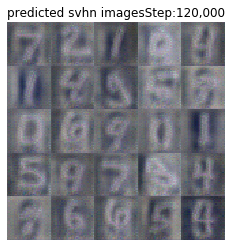

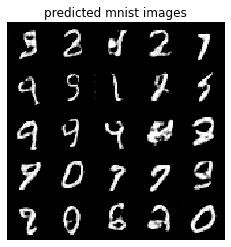

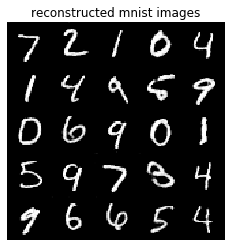

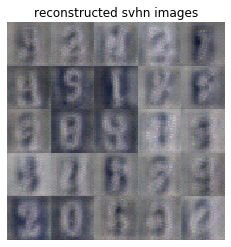

125000:[d_A loss:0.085872]:[d_B loss:0.000288][adv loss:4.699233]


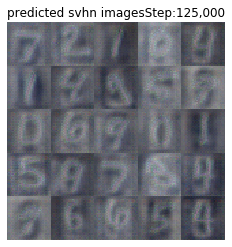

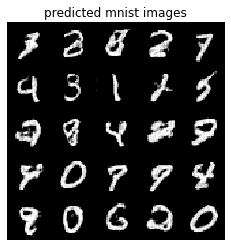

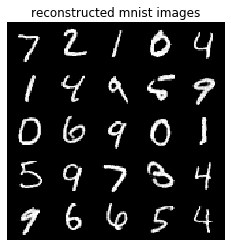

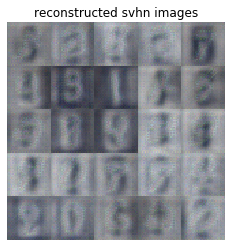

130000:[d_A loss:0.255653]:[d_B loss:0.000194][adv loss:4.411898]


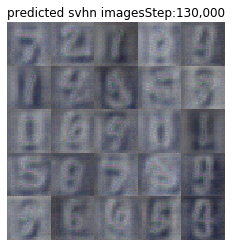

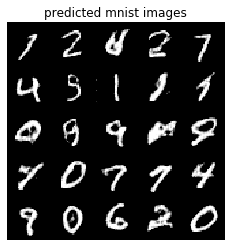

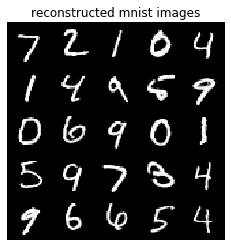

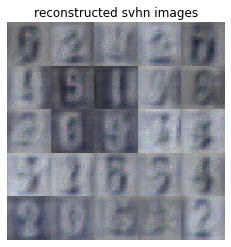

135000:[d_A loss:0.233570]:[d_B loss:0.000468][adv loss:5.165152]


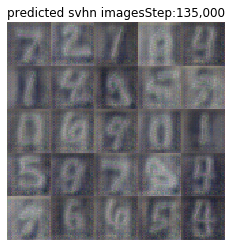

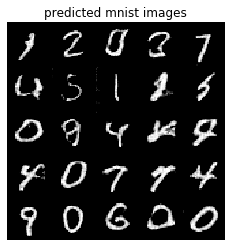

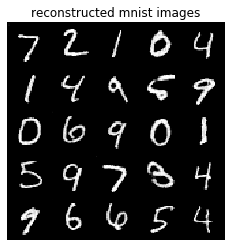

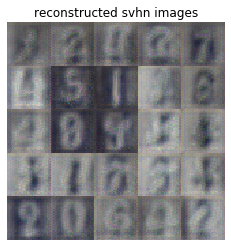

140000:[d_A loss:0.105981]:[d_B loss:0.050586][adv loss:5.348657]


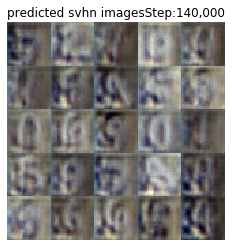

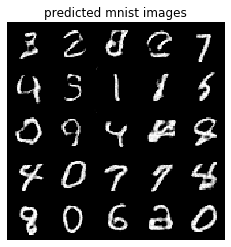

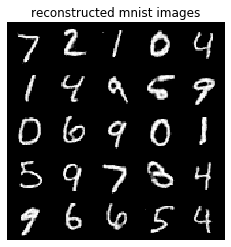

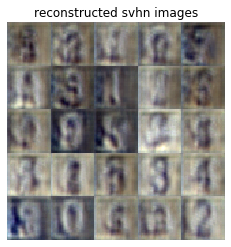

145000:[d_A loss:0.003444]:[d_B loss:0.000167][adv loss:4.291162]


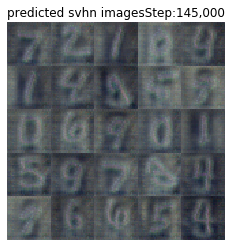

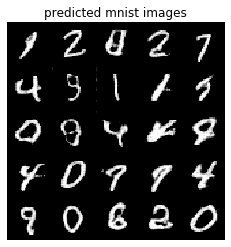

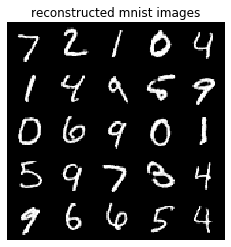

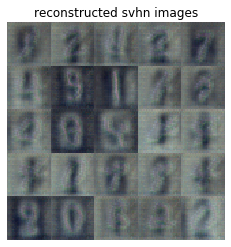

150000:[d_A loss:0.272585]:[d_B loss:0.000321][adv loss:4.345980]


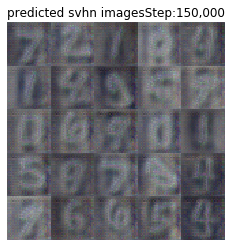

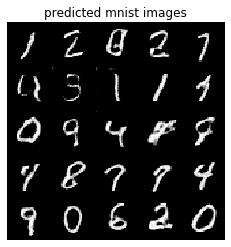

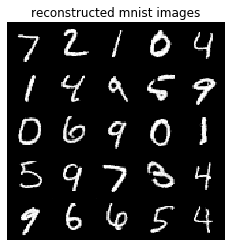

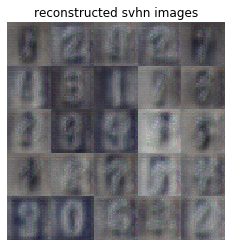

In [6]:
import mnist_SVHN
batch_size=2
train_steps=150000
patchgan=True
identity=False
save_interval=5000
kernel_size=5
gen_n_filters=32
dis_n_filters=32


data, shapes=mnist_SVHN.load_mnist_svhn()
print(shapes)
A_data,B_data,test_A_data,test_B_data=data
titles=('predicted mnist images', "predicted svhn images", 'reconstructed mnist images','reconstructed svhn images')
B_size=int(B_data.shape[0])
A_size=int(A_data.shape[0])

models=build_cyclegan(shapes,gen_n_filters,dis_n_filters,kernel_size,patchgan=patchgan,identity=identity)
d_A,d_B,g_AB,g_BA,adv=models

if patchgan:
    patch=int(A_data.shape[1]/2**4)
else:
    patch=1

if patch>1:
    d_patch=(patch,patch,1)
    valid=np.ones((batch_size,)+d_patch)
    fake=np.zeros((batch_size,)+d_patch)
else:
    valid=np.ones([batch_size,1])
    fake=np.zeros([batch_size,1])
    
for step in range(train_steps):
    rand_index=np.random.randint(0,B_size,size=batch_size)
    real_B=B_data[rand_index]
    rand_index=np.random.randint(0,A_size,size=batch_size)
    real_A=A_data[rand_index]
    
    fake_B=g_AB.predict(real_A)
    fake_A=g_BA.predict(real_B)
    
    dA_loss_real=d_A.train_on_batch(real_A, valid)
    dA_loss_fake=d_A.train_on_batch(fake_A, fake)
    dA_loss=0.5*np.add(dA_loss_real,dA_loss_fake)
    log="%d:[d_A loss:%f]" % (step+1,dA_loss)
    
    dB_loss_real=d_B.train_on_batch(real_B, valid)
    dB_loss_fake=d_B.train_on_batch(fake_B, fake)
    dB_loss=0.5*np.add(dB_loss_real,dB_loss_fake)
    log='%s:[d_B loss:%f]' %(log,dB_loss)
    
    if identity:
        adv_loss=adv.train_on_batch([real_A,real_B],[valid,valid,real_A, real_B,real_A,real_B])
        log='%s[adv loss:%f]'%(log,adv_loss[0])
    else:
        adv_loss=adv.train_on_batch([real_A,real_B], [valid,valid,real_A, real_B])
        log='%s[adv loss:%f]'%(log,adv_loss[0])
    
    if (step+1)%save_interval==0:
        print(log)
        if (step+1)==train_steps:
            show=True
        else:
            #show=False
            show=True
    
        import other_utils
        other_utils.test_generator((g_BA, g_AB),(test_A_data,test_B_data), step=step+1, titles=titles,show=show)

In [7]:
from tf.keras.models import load_model
g_AB.save('mnist_svhn_g_AB.h5')
g_BA.save('mnist_svhn_g_BA.h5')

#generator_AB=load_model('cifar10g_AB.h5')
#generator_BA=load_model('cifar10g_BA.h5')

In [3]:
from scipy import io
B_data_mat=io.loadmat("C:/Users/ysp/Desktop/Deep Learning/train_32x32.mat")
test_B_mat=io.loadmat("C:/Users/ysp/Desktop/Deep Learning/test_32x32.mat")
B_data_mat['X'].shape


(32, 32, 3, 73257)

pip install git+https://www.github.com/keras-team/keras-contrib.git

In [2]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Using TensorFlow backend.
